In [1]:
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [2]:
import os
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
%matplotlib inline

In [3]:
BATCH_SIZE = 256
START_TOKN, END_TOKN, PAD_TOKN = "<", ">", "-"

In [4]:
f = open('names.txt', 'r', encoding='utf-8')
raw_names = f.read().split("\n")
f.close()

raw_names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
MAX_LEN = max([len(name) for name in raw_names]) + 2 # 2 extra characters for START_TOKN and END_TOKN
MAX_LEN

17

In [6]:
CHARS = sorted(list(set("".join(raw_names)))) + [START_TOKN, END_TOKN, PAD_TOKN] # add special characters at the end
"".join(CHARS)

'abcdefghijklmnopqrstuvwxyz<>-'

In [7]:
stoi = {ch: i for i, ch in enumerate(CHARS)}
itos = {i: ch for i, ch in enumerate(CHARS)}

text = START_TOKN + "hello" + PAD_TOKN + "world" + END_TOKN
"".join([itos[i] for i in [stoi[ch] for ch in text]])

'<hello-world>'

In [8]:
START_IDX, END_IDX, PAD_IDX = stoi[START_TOKN], stoi[END_TOKN], stoi[PAD_TOKN]

START_IDX, END_IDX, PAD_IDX

(26, 27, 28)

In [9]:
class NameDataset(Dataset):
    def __init__(self, names):
        self.x = []
        self.y = []
        for name in names:
            name = (START_TOKN + name + END_TOKN + PAD_TOKN*MAX_LEN)[:MAX_LEN]
            self.x.append([stoi[ch] for ch in name[:-1]])
            self.y.append([stoi[ch] for ch in name[1:]])
        self.x = torch.tensor(self.x)
        self.y = torch.tensor(self.y)     
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [10]:
split = int(len(raw_names)*0.9)
random.seed(42)
random.shuffle(raw_names)
train_data = NameDataset(raw_names[:split])
val_data = NameDataset(raw_names[split:])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=RandomSampler(train_data, replacement=True, num_samples=BATCH_SIZE))
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

len(train_loader), len(val_loader)

(1, 13)

In [11]:
class GRU(nn.Module):
    def __init__(self, in_emb=32, out_emb=64):
        super().__init__()
        self.reset = nn.Linear(in_emb+out_emb, out_emb)
        self.x_bar = nn.Linear(in_emb+out_emb, out_emb)
        self.blend = nn.Linear(in_emb+out_emb, out_emb)
        self.norm = nn.LayerNorm(out_emb)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x_t, h_t):
        B, _ = x_t.shape                                   # (B, in_emb)
        xh_t = torch.cat([x_t, h_t], dim=1)                # (B, in_emb+out_emb)
        reset = torch.sigmoid(self.reset(xh_t))            # (B, out_emb)
        t_reset = h_t * reset                              # (B, out_emb)
        x_reset = torch.cat([x_t, t_reset], dim=1)         # (B, in_emb+out_emb)
        x_bar = torch.tanh(self.x_bar(x_reset))            # (B, out_emb)
        blend = torch.sigmoid(self.blend(xh_t))            # (B, out_emb)
        logits = blend*x_bar + (1 - blend)*h_t             # (B, out_emb)
        logits = self.dropout(self.norm(logits))           # (B, out_emb)
        return logits

In [12]:
class RNN(nn.Module):
    def __init__(self, in_emb=32, out_emb=64):
        super().__init__()
        self.embedding = nn.Embedding(len(CHARS), in_emb)
        self.h_0 = nn.Parameter(torch.zeros(1, out_emb))
        self.gru = GRU(in_emb, out_emb)
        self.decoder = nn.Linear(out_emb, len(CHARS))
        
    def get_h_0(self):
        return self.h_0.detach().expand(1, -1)             # (1, out_emb)

    def embed(self, x_t):
        return self.embedding(x_t)                         # (B,) → (B, in_emb)

    def step(self, x_t, h_t):
        x_t_emb = self.embed(x_t)
        return self.gru(x_t_emb, h_t)                      # (B, out_emb)

    def decode(self, h_t):
        return self.decoder(h_t)                           # (B, out_emb) → (B, vocab)

    def forward(self, x):
        B, T = x.shape
        h_t = self.h_0.expand(B, -1)                       # (B, out_emb)
        history = []

        for i in range(T):
            h_t = self.step(x[:, i], h_t)                  # x[:, i]: (B,)
            history.append(h_t)

        return self.decode(torch.stack(history, dim=1))    # (B, T, vocab)

In [13]:
@torch.no_grad
def get_accuracy(logits, y):
    outs = logits.argmax(dim=2)
    mask = (y != PAD_IDX)
    matches = (y == outs) & mask
    num_matches = matches.sum().item()
    num_total = mask.sum().item()
    if num_total == 0:
        return float('nan')
    else:
        return 100.0 * num_matches / num_total

In [14]:
def train(model, loader, steps=100, lr=1e-2):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    stats = {"loss": [], "ratio": [], "accuracy": []}
    model.to("cuda")
    model.train()
    
    for _ in range(steps):
        x, y = next(iter(loader))
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = criterion(logits.view(-1, len(CHARS)), y.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():        
            stats["loss"].append(loss.item())
            ratios = []
            for p in model.parameters():
                if p.grad is None:
                    continue
                update_mean = ((lr * p.grad)**2).mean().item()
                weight_mean = ((p.data)**2).mean().item()
                if weight_mean == 0:
                    ratios.append(np.nan)
                else:
                    ratios.append(update_mean/weight_mean)
            stats["ratio"].append(ratios)
            accuracy = get_accuracy(logits, y)
            stats["accuracy"].append(accuracy)
    return stats

In [15]:
@torch.no_grad()
def validate(model, loader):
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    stats = {"loss": [], "accuracy": []}
    model.to("cuda")
    model.eval()
    
    for x, y in loader:
        x, y = x.to("cuda"), y.to("cuda")
        logits = model(x)
        loss = criterion(logits.view(-1, len(CHARS)), y.view(-1))
        stats["loss"].append(loss.item())
        stats["accuracy"].append(get_accuracy(logits, y))
    return stats

In [16]:
@torch.no_grad()
def makemore(model, starter=""):
    model.eval()
    model.to("cuda")

    output = list(starter)
    h_t = model.get_h_0()

    for ch in ["<"] + list(starter):
        x_t = torch.tensor([stoi[ch]], device="cuda")
        h_t = model.step(x_t, h_t)

    while True:
        logits = model.decode(h_t)
        probs = F.softmax(logits, dim=-1)
        y_ix = torch.multinomial(probs, num_samples=1).item()
        y = itos[y_ix]

        if y == END_TOKN:
            break
        elif y in [START_TOKN, PAD_TOKN]:
            continue

        output.append(y)
        x_t = torch.tensor([stoi[y]], device="cuda")
        h_t = model.step(x_t, h_t)

    return "".join(output)

In [17]:
stats = {"loss": [], "ratio": [], "accuracy": []}

model = RNN(in_emb=32, out_emb=256)
model.to("cuda")
sum(p.numel() for p in model.parameters())

231101

In [24]:
epochs = 15

print("Training...")
for epoch in range(epochs):
    train_stats = train(model, train_loader, steps=100, lr=10**(-2))
    stats["loss"].extend(train_stats["loss"])
    stats["ratio"].extend(train_stats["ratio"])
    stats["accuracy"].extend(train_stats["accuracy"])
    train_loss = sum(train_stats["loss"])/len(train_stats["loss"])
    train_acc = sum(train_stats["accuracy"])/len(train_stats["accuracy"])
    if (((epoch+1) % max(1, (epochs//10))) == 0) or (epoch+1 == epochs):
        val_stats = validate(model, val_loader)
        val_loss = sum(val_stats["loss"])/len(val_stats["loss"])
        val_acc = sum(val_stats["accuracy"])/len(val_stats["accuracy"])
        print(f"""Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.4f}, 
              Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Total Steps: {len(stats["loss"])}""")

Training...
Epoch: 1, Training Loss: 1.8681, Training Acc: 40.4313, 
              Val Loss: 1.9437, Val Acc: 38.8206, Total Steps: 2600
Epoch: 2, Training Loss: 1.8624, Training Acc: 40.6451, 
              Val Loss: 1.9494, Val Acc: 38.8016, Total Steps: 2700
Epoch: 3, Training Loss: 1.8627, Training Acc: 40.5344, 
              Val Loss: 1.9473, Val Acc: 38.6314, Total Steps: 2800
Epoch: 4, Training Loss: 1.8615, Training Acc: 40.5484, 
              Val Loss: 1.9449, Val Acc: 38.8538, Total Steps: 2900
Epoch: 5, Training Loss: 1.8568, Training Acc: 40.7056, 
              Val Loss: 1.9414, Val Acc: 38.3950, Total Steps: 3000
Epoch: 6, Training Loss: 1.8569, Training Acc: 40.6059, 
              Val Loss: 1.9500, Val Acc: 38.6668, Total Steps: 3100
Epoch: 7, Training Loss: 1.8506, Training Acc: 40.8843, 
              Val Loss: 1.9448, Val Acc: 38.7509, Total Steps: 3200
Epoch: 8, Training Loss: 1.8491, Training Acc: 40.7789, 
              Val Loss: 1.9426, Val Acc: 38.7150, Total 

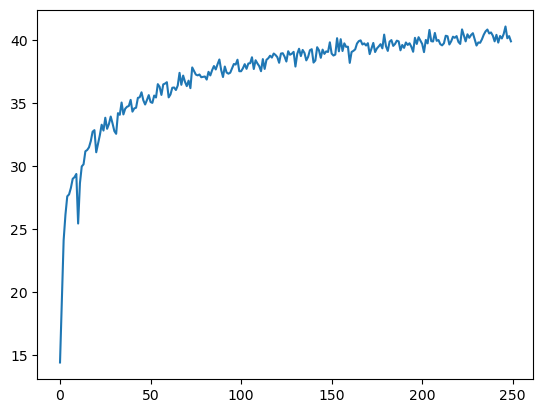

250

In [19]:
accuracy = torch.tensor(stats["accuracy"])
accuracy = accuracy.view(-1, 10).mean(dim=1)
plt.plot(accuracy)
plt.show()
len(accuracy)

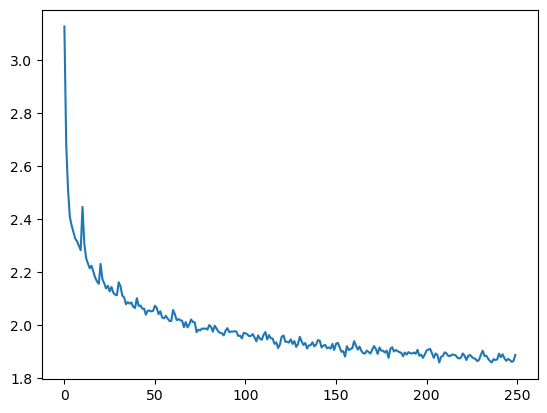

250

In [20]:
losses = torch.tensor(stats["loss"])
losses = losses.view(-1, 10).mean(dim=1)
plt.plot(losses)
plt.show()
len(losses)

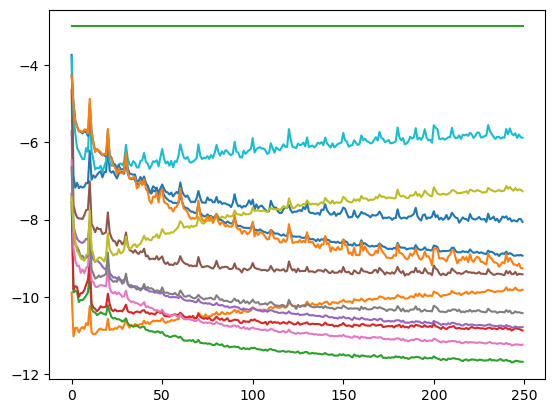

In [22]:
ratios = torch.tensor(stats['ratio'])
_layers = ratios.shape[1]
ratios = ratios.view(-1, 10, _layers).mean(dim=1).T.log10()
for ratio in ratios:
    plt.plot(ratio)
e3 = torch.ones_like(ratio)*(-3)
plt.plot(e3)
plt.show()

In [23]:
N, P = 10**(3), 20

gen_names = {True: [], False: []}
for i in range(N):
    name = makemore(model)
    key = (name in raw_names)
    gen_names[key].append(name)
    if i < P:
        print(f"{name}: {key}")
    
print(len(gen_names[False])/N)

ellina: True
celie: False
amara: True
adamial: False
dver: False
hasnia: False
phyna: False
aaryan: True
diu: False
carif: False
marciona: False
atvi: False
shafari: False
rutavieve: False
asma: True
maylam: False
khali: True
lainie: True
rachel: True
bellyn: False
0.636
